# Mods

In [2]:
# pip install Dask ;
# pip install pysqlite ;
# pip install pandas ;
# pip install scikit-learn ;
# pip install group_lasso ;
# pip install numpy
# pip install asgl
# pip install groupry 

In [106]:
import numpy as np
import pandas as pd
# import asgl
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


import sqlite3
import warnings
warnings.filterwarnings('ignore')

In [2]:
Df = pd.read_csv("/home/r00323024/Xwines.csv")


# data process

In [107]:
df = Df

df = df[df["Vintage"] != "N.V."]


df["Vintage"] = pd.to_numeric(df["Vintage"])


df = df[df['Vintage'] >= 2005]


df["Vintage"] = df["Vintage"].astype(str)


df['Date'] = pd.to_datetime(df['Date'])


df['min_date'] = df.groupby(['Vintage', 'UserID', 'WineName'])['Date'].transform('min')


df = df[df['Date'] == df['min_date']]


df = df.drop_duplicates(subset=['Vintage', 'UserID', 'WineName'])


Type = ['Red', 'White']
df = df[df['Type'].isin(Type)]
        

winery_counts = df.groupby("WineryName").size()


df['amount'] = df['WineryName'].map(winery_counts)


df = df[df['amount'] >= 10000]


labels = df['WineryName'] + ' ' + df['Vintage']
df["Label"] = labels

scaler = StandardScaler()
df['Rating'] = scaler.fit_transform(df[['Rating']])

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2645807 entries, 53148 to 8590802
Data columns (total 25 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RatingID    int64         
 1   UserID      int64         
 2   WineID      int64         
 3   Vintage     object        
 4   Rating      float64       
 5   Date        datetime64[ns]
 6   WineName    object        
 7   Type        object        
 8   Elaborate   object        
 9   Grapes      object        
 10  Harmonize   object        
 11  ABV         float64       
 12  Body        object        
 13  Acidity     object        
 14  Code        object        
 15  Country     object        
 16  RegionID    int64         
 17  RegionName  object        
 18  WineryID    int64         
 19  WineryName  object        
 20  Website     object        
 21  Vintages    object        
 22  min_date    datetime64[ns]
 23  amount      int64         
 24  Label       object        
dtypes: datetime64[ns](2

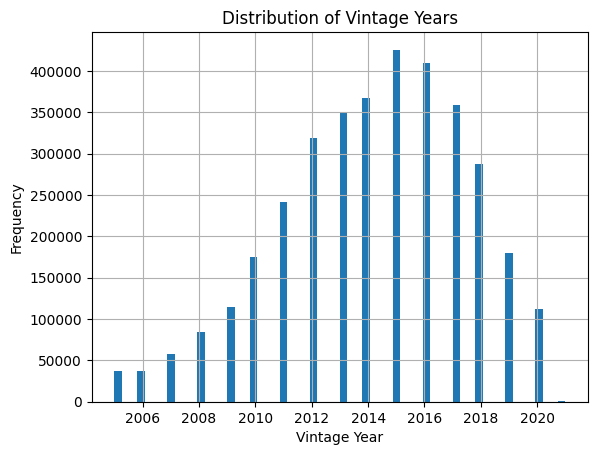

In [76]:
# stat plot

df["Vintage"]=df["Vintage"].astype(int)
df['Vintage'].hist(bins=60)  # bins參數控制直方圖中的條柱數量
plt.title('Distribution of Vintage Years')
plt.xlabel('Vintage Year')
plt.ylabel('Frequency')
plt.show()


In [108]:
columns_to_drop = ["RatingID","WineID","Date","Elaborate", "Grapes","Harmonize","ABV","Code","RegionID","RegionName", "Website" ,"WineryID","Vintages","min_date","amount"]
columns_to_drop_existing = [col for col in columns_to_drop if col in df.columns]
if columns_to_drop_existing:
    df.drop(columns=columns_to_drop_existing, inplace=True)

In [109]:
#去識別化

columns_to_group = ["Vintage" ,'WineName','Type','Body','Acidity','Country',"WineryName","Label"]
df =df.groupby(columns_to_group)['Rating'].mean().reset_index()

In [15]:
# def abv_category(abv):
#     if abv < 4:
#         return '0-3.99%'
#     elif abv < 8:
#         return '4-7.99%'
#     elif abv < 12:
#         return '8-11.99%'
#     elif abv < 16:
#         return '12-15.99%'
#     elif abv < 20:
#         return '16-19.99%'
#     else:
#         return '20%以上'

# df['ABV'] = df['ABV'].apply(abv_category)


# OLS

In [110]:
%load_ext sql
%sql sqlite://

conn = sqlite3.connect(':memory:')  # Use ':memory:' for in-memory database

df.to_sql('table1', conn, index=False, if_exists='replace')

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


21795

In [111]:
Rating = pd.read_sql_query("SELECT Rating FROM table1;", conn)
Type = pd.read_sql_query("SELECT Type FROM table1;", conn)
Acidity = pd.read_sql_query("SELECT Acidity FROM table1;", conn)
Body = pd.read_sql_query("SELECT Body FROM table1;", conn)
Label = pd.read_sql_query("SELECT Label FROM table1;", conn)


In [112]:
Type_dum = pd.get_dummies(Type,drop_first=True, sparse=True).astype(int)
Acidity_dum = pd.get_dummies(Acidity,drop_first=True, sparse=True).astype(int)
Body_dum = pd.get_dummies(Body,drop_first=True, sparse=True).astype(int)
Label_dum = pd.get_dummies(Label,drop_first=True, sparse=True).astype(int)

In [113]:
test_df = pd.DataFrame(index=Type_dum.index)

dfs = [Type_dum,Acidity_dum,Body_dum,Label_dum] 
for i in dfs:
    test_df = pd.concat([test_df, i], axis=1)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21795 entries, 0 to 21794
Columns: 2213 entries, Type_White to Label_Zenato 2021
dtypes: int64(2213)
memory usage: 368.0 MB


In [114]:
X = sm.add_constant(test_df)  
y = Rating

In [116]:

model = sm.OLS(y, X)
results = model.fit()

def format_pvalues(pval):
    if pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    else:
        return ''


summary = results.summary()

tables = summary.tables[1].data  
headers = tables.pop(0)  
Result = pd.DataFrame(tables, columns=headers)

Result['P>|t|'] = Result['P>|t|'].astype(float).apply(lambda x: f"{x:.3f}" + format_pvalues(x))


In [117]:

file_path = "/home/r00323024/OLS.txt"
with open(file_path, "w") as f:
     f.write(Result.to_string())

# LASSO

In [14]:
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建带交叉验证的LASSO模型，这里设置交叉验证的折数为5
lasso_cv = LassoCV(cv=5, random_state=42)

# 拟合模型
lasso_cv.fit(X_train, y_train)

# 查看最佳的alpha值
best_alpha = lasso_cv.alpha_
print("Best alpha found through cross-validation:", best_alpha)

# 使用找到的最佳alpha值在测试集上评估模型
y_pred = lasso_cv.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)


Best alpha found through cross-validation: 2.8602670351817206e-05
Mean Squared Error on Test Set: 0.3548152215626057


In [15]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 重新使用最佳 alpha 值创建 LASSO 模型
lasso = Lasso(alpha=2.8602670351817206e-05)

# 在整个训练集上重新训练模型
lasso.fit(X_train, y_train)

# 对测试集进行预测
y_pred = lasso.predict(X_test)

# 计算 Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

# 将结果和一些模型细节保存到 DataFrame
results_df = pd.DataFrame({
    "Best Alpha": [2.8602670351817206e-05],
    "Test MSE": [mse],
    "Coefficients": [lasso.coef_]
})

# 指定文件路径
file_path = "/home/r00323024/LASSORW.txt"

# 将结果写入文件
with open(file_path, "w") as f:
    f.write(results_df.to_string())


Mean Squared Error on Test Set: 0.3548152215626057


# SGL

In [36]:
y = Rating.values
X = final_df.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=10
)


ranges = [
    (0, 4), # Type
    (5,8), # Body
    (9, 10), # Acidity
    (11, 1545), #Grapes
    (1546, 1616), # Vintage
    (1617, 1626), # Region
    (1627, 2308) # Region_Vintage
]
arrays = [np.arange(start, end + 1) for start, end in ranges]
arrays

In [ ]:
import groupyr as gpr
# Fit an SGL model for this data
cv = KFold(n_splits=5, shuffle=True, random_state=1729) 
sgl = gpr.SGLCV(
    groups=arrays).fit(X, y)

In [44]:
import asgl
lambda1 = (10.0 ** np.arange(-3, 1.51, 0.2)) # 23 possible values for lambda
alpha = np.arange(0, 1, 0.05) # 20 possible values for alpha

# Define model parameters
model = 'lm'  # linear model
penalization = 'sgl'  # sparse group lasso penalization
parallel = True  # Code executed in parallel
error_type = 'MSE'  # Error measuremente considered. MSE stands for Mean Squared Error.


In [46]:


X, y, groups, coef = gpr.datasets.make_group_regression(
    n_samples=400,
    n_groups=50,
    n_informative_groups=5,
    n_features_per_group=20,
    n_informative_per_group=18,
    noise=500,
    coef=True,
    random_state=10,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=10
)

# Fit an SGL model for this data
cv = KFold(n_splits=5, shuffle=True, random_state=1729)  # Set shuffle=True here
sgl = gpr.SGLCV(
    groups=groups, cv=cv, l1_ratio=[0.0, 1.0], tuning_strategy="bayes", n_bayes_iter=50
).fit(X_train, y_train)




# Stat

In [ ]:

# plt.figure(figsize=(12, 36)) 

# plt.subplot(6, 1, 1)  
# sns.distplot(df['ABV'])

# plt.subplot(6, 1, 2)  
# sns.histplot(df2['Body'], bins=len(df2['Body'].unique()))
# plt.xticks(rotation=45)

# plt.subplot(6, 1, 3)  
# sns.histplot(df2['Acidity'], bins=len(df2['Acidity'].unique()))

# plt.subplot(6, 1, 4)  
# sns.histplot(df2['Type'], bins=len(df2['Type'].unique()))

# plt.subplot(6, 1, 5)  # 6行1列的第5張圖
# sns.histplot(df2['Country'], bins=len(df2['Country'].unique()))
# plt.xticks(rotation=90)  # 旋轉標籤以避免重疊

# plt.subplot(6, 1, 6)  # 6行1列的第6張圖
# sns.histplot(df2['Elaborate'], bins=len(df2['Elaborate'].unique()))
# plt.xticks(rotation=45)

# plt.tight_layout()  # 調整子圖之間的間距
# plt.show()


In [32]:
def count(column_name, dataframe):
    return len(dataframe[column_name].unique())

cols = ["Type", "Body","Acidity","Grapes", "Vintage","Region","Region_Vintage" ,"WineryName" , "WineryName_Vintage"]

for i in cols:
    print(f"Number of unique values in {i}: {count(i, dfnew)}")

Number of unique values in Type: 6
Number of unique values in Body: 5
Number of unique values in Acidity: 3
Number of unique values in Grapes: 1536
Number of unique values in Vintage: 72
Number of unique values in Region: 12
Number of unique values in Region_Vintage: 752
Number of unique values in WineryName: 5795
Number of unique values in WineryName_Vintage: 127577


In [6]:
# unique_wines = df["WineName"].unique()
# file_path = "/home/r00323024/unique_wines.txt"
# with open(file_path, "w") as f:
#     for wine in unique_wines:
#         f.write(f"{wine}\n")

# Grapes = df["Grapes"].unique()
# file_path = "/home/r00323024/unique_Grapes.txt"
# with open(file_path, "w") as f:
#     for Grape in Grapes:
#         f.write(f"{Grape}\n")

# Vintage = dfnew["Vintage"].unique()
# file_path = "/home/r00323024/unique_Vintage.txt"
# with open(file_path, "w") as f:
#     for i in Vintage:
#         f.write(f"{i}\n")

# WineryName = df["WineryName"].unique()
# file_path = "/home/r00323024/unique_WineryName.txt"
# with open(file_path, "w") as f:
#     for i in WineryName:
#         f.write(f"{i}\n")

# Country = df["Country"].unique()
# file_path = "/home/r00323024/unique_Country.txt"
# with open(file_path, "w") as f:
#     for i in Country:
#         f.write(f"{i}\n")

In [7]:
# grape_varieties = dfnew["Grapes"]

# # We need to convert the strings back to lists and flatten them to count unique grapes
# all_grapes = set()

# for line in grape_varieties:
#     # Convert the string list representation to an actual list
#     variety_list = ast.literal_eval(line.strip())
#     # Add each variety in the list to a set to ensure uniqueness
#     for variety in variety_list:
#         all_grapes.add(variety)

# # Count of unique grape varieties
# total_unique_grapes = len(all_grapes)
# all_grapes, total_unique_grapes

# file_path = "/home/r00323024/unique_Grape.txt"
# with open(file_path, "w") as f:
#     for i in all_grapes:
#         f.write(f"{i}\n")